In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import scipy.stats as stats

In [2]:
analysis_results = pd.read_csv('/mnt/analysis/e17023/Adam/GADGET2/Analysis/sim_data.csv')
parameters = pd.read_csv('/mnt/analysis/e17023/Adam/GADGET2/simOutput/parameters.csv')

# combine the two dataframes into one
parameters = parameters.rename(columns={'N':'N_sim'})

# set Sim to be the index for both dataframes
analysis_results = analysis_results.set_index('sim')
parameters = parameters.set_index('Sim')

# combine the two dataframes
combined = pd.concat([parameters, analysis_results], axis=1)

In [3]:
parameters_list = parameters.columns.tolist()
[parameters_list.remove(i) for i in ['N_sim', 'P0', 'P1', 'Status']]
len(parameters_list)

12

In [4]:
analysis_list = analysis_results.columns.tolist()
analysis_list.remove('N')
len(analysis_list)

28

In [5]:
param_k = pd.DataFrame(index=parameters_list, columns=analysis_list)

for i in parameters_list:
    p = parameters_list.index(i)
    for j in analysis_list:
        a = analysis_list.index(j)
        
        best_C = 0
        best_k = 0
        best_R = 0
        for k in np.linspace(-10,10,201): # try k from 0 to 10
            
            X = combined[parameters_list].values
            if k != 0:
                X = np.hstack([np.ones((X.shape[0], 1)), X])
                if k == -10: # if k is -10, take the log of the parameter
                    X[:,p+1] = np.log(X[:,p+1])
                else:
                    X[:,p+1] = X[:,p+1]**k # raise the parameter to the power of k
            else:
                X[:,p] = X[:,p]**k # raise the parameter to the power of k (k=0)
            Y = combined[j].values
            
            beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
            
            if k != 0:
                Contr = beta[p+1] * parameters[i].mean() / analysis_results[j].mean()
            else:
                Contr = beta[p] * parameters[i].mean() / analysis_results[j].mean()
            
            R2 = 1 - np.sum((Y - X.dot(beta))**2) / np.sum((Y - Y.mean())**2) # R^2
            
            if np.abs(R2) > np.abs(best_R):
                if np.abs(Contr) > 0.05 and np.abs(Contr) < 1:
                    best_C = Contr
                    best_k = k
                    best_R = R2
            
        
        #print(i,j,best_C, best_k, best_R)
        param_k.loc[i,j] = round(best_k, 2)
        param_k.to_csv('/mnt/analysis/e17023/Adam/GADGET2/Analysis/param_k.csv')

Text(0.5, 1.0, 'R2 for power transformed data')

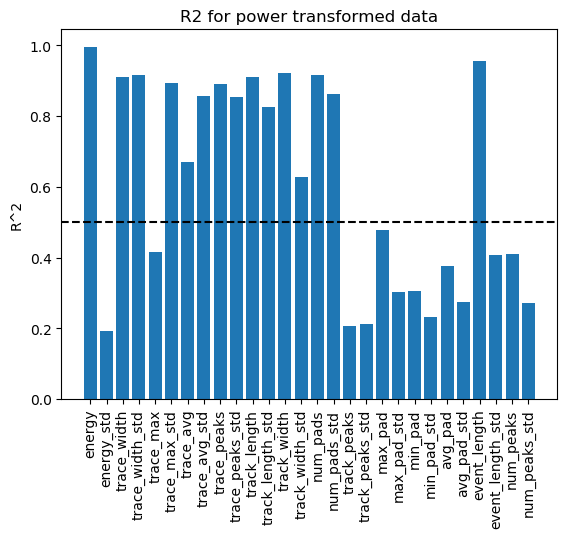

In [6]:
R2k_list = []
for i,a in enumerate(analysis_list):
    X = combined[parameters_list].values
    dl = []
    for j,p in enumerate(parameters_list):
        k = param_k.loc[p,a]
        if k == -10:
            X[:,j] = np.log(X[:,j])
        else:
            X[:,j] = X[:,j]**k # raise the parameter to the power of k
        if k == 0:
            dl.append(j)
    X = np.delete(X, dl, axis=1)
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    Y = combined[a].values
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
    R2 = 1 - np.sum((Y - X.dot(beta))**2) / np.sum((Y - Y.mean())**2) # R^2
    R2k_list.append(R2)

plt.bar(analysis_list, R2k_list)
plt.xticks(rotation=90)
plt.ylabel('R^2')
plt.axhline(y=0.5, color='k', linestyle='--');
plt.title('R2 for power transformed data')

Text(0.5, 1.0, 'R2 for non-power transformed data')

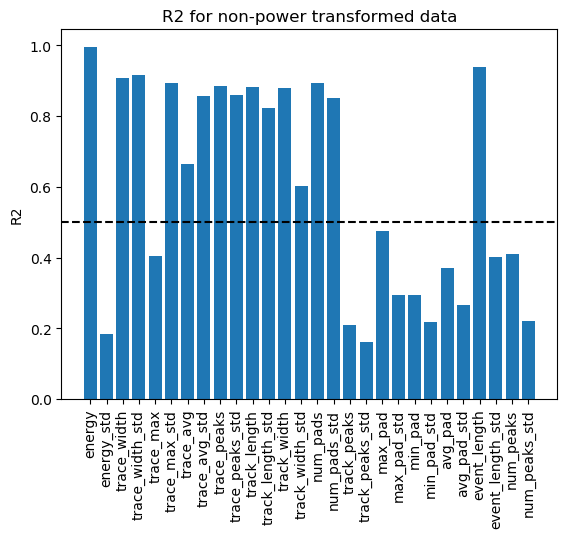

In [7]:
R2_list = []
for i, j in enumerate(analysis_list):
    X = combined[parameters_list].values
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    
    y = combined[j].values
    
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    y_hat = X.dot(beta)
    y_bar = np.mean(y, axis=0)
    SS_tot = np.sum((y - y_bar)**2, axis=0)
    SS_res = np.sum((y - y_hat)**2, axis=0)
    R2 = 1 - SS_res/SS_tot
    R2_list.append(R2)

plt.bar(analysis_list, R2_list)
plt.xticks(rotation=90)
plt.ylabel('R2')
plt.axhline(y=0.5, color='k', linestyle='--');
plt.title('R2 for non-power transformed data')

0.011970007445483235


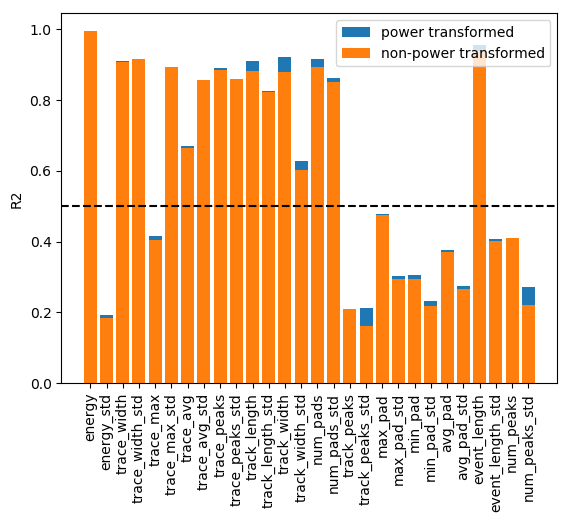

In [8]:
plt.bar(analysis_list, R2k_list, label='power transformed')
plt.bar(analysis_list, R2_list, label='non-power transformed')
plt.xticks(rotation=90)
plt.ylabel('R2')
plt.axhline(y=0.5, color='k', linestyle='--');
plt.legend()

improvement = [R2k_list[i] - R2_list[i] for i in range(len(R2k_list))]
print(np.mean(improvement))